In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Flatten, Input
from keras.losses import BinaryCrossentropy
import time

c:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
image_directory = "C:\\Users\\allan\\Downloads\\NFTGAN\\bayc"
image_dimension = 128
noise_dimensions = 128

In [3]:
def create_dataset(directory_path):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory_path,
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        image_size=(image_dimension, image_dimension),
        shuffle=True,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )
    dataset = dataset.map(map_dataset)
    return dataset

def map_dataset(datapoint):
    return (datapoint-127.5)/127.5

def plot_image(image_tensor):
    plt.imshow(image_tensor*0.5 + 0.5)
    plt.show()

In [4]:
dataset = create_dataset(image_directory)

Found 10000 files belonging to 1 classes.


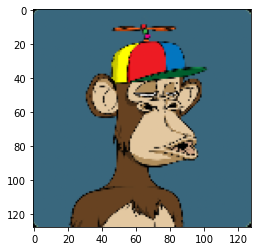

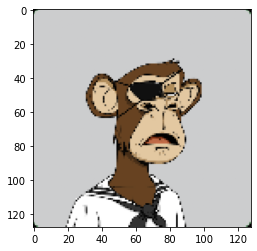

In [5]:
for batch in dataset.take(2):
    single_image = batch[0]
    plot_image(single_image)

In [6]:
#Build an auto encoder for the generator
first_layer_filters = 128
kernel_size = 4
autoencoder_generator = tf.keras.models.Sequential([

    #Encoding layers
    Input(shape=[noise_dimensions]),
    Dense(units = image_dimension*image_dimension*3),
    Reshape(target_shape=(image_dimension, image_dimension, 3)),
    Conv2D(filters = first_layer_filters, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = first_layer_filters*2, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = first_layer_filters*4, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),

    #Bottleneck layer
    Conv2D(filters = first_layer_filters*8, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),

    #Decoding layers
    Conv2DTranspose(filters = first_layer_filters*4, kernel_size=kernel_size, strides = 2, padding = 'same', activation='selu', use_bias=False),
    BatchNormalization(),
    Conv2DTranspose(filters = first_layer_filters*2, kernel_size=kernel_size, strides = 2, padding = 'same', activation='selu', use_bias=False),
    BatchNormalization(),
    Conv2DTranspose(filters = first_layer_filters, kernel_size=kernel_size, strides = 2, padding = 'same', activation='selu', use_bias=False),
    BatchNormalization(),
    Conv2DTranspose(filters = 3, kernel_size=kernel_size, strides = 2, padding = 'same', activation='tanh', use_bias=False),
])

In [7]:
#Build a normal encoder with a single output neuron as a discriminator
discriminator_filters = 64
kernel_size = 4
discriminator = tf.keras.models.Sequential([
    Input(shape = (image_dimension, image_dimension, 3)),
    Conv2D(filters = discriminator_filters, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = discriminator_filters*2, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = discriminator_filters*4, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = discriminator_filters*8, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    #Dense(units = 128, activation=LeakyReLU()),
    Dense(units = 1, activation='sigmoid')
])

In [8]:
#Define separate optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

In [9]:
#Define a loss function. It just calculates loss, so one is enough for both models
loss_function = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
#Define some metrics to evaluate accuracy
discriminator_fake_accuracy = tf.keras.metrics.BinaryAccuracy()
discriminator_real_accuracy = tf.keras.metrics.BinaryAccuracy()


In [10]:
def train_the_model(dataset, epochs, noise_dimensions, GAN):
    generator, discriminator = GAN.layers
    for epoch in range(epochs):
        discriminator_losses = []
        generator_losses = []
        fake_accuracy = None
        real_accuracy = None
        start_time = time.time()
        for batch in dataset:
            #Get the batch size
            batch_size = batch.shape[0]

            #PHASE 1 TRAIN THE DISCRIMINATOR
            with tf.GradientTape() as discriminator_tape:
                #Create noise which will be the input to the generator
                noise = tf.random.normal(shape=[batch_size, noise_dimensions])
                #Pass the noise into the generator to get fake images
                fake_images = generator(noise)
                #Pass the fake images into the discriminator to get fake output (0s)
                fake_output = discriminator(fake_images)
                #Pass the real images from the batch into the discriminator to get real output (1s)
                real_output = discriminator(batch)
                #Create a tensor of 0s as labels for the fake output
                fake_labels = tf.constant(0, shape = (batch_size, 1), dtype=tf.int32)
                #Create a tensor of 1s as labels for the real output
                real_labels = tf.constant(1, shape = (batch_size, 1), dtype=tf.int32)
                #Calculate loss for fake outputs
                fake_loss = loss_function(y_pred=fake_output, y_true=fake_labels)
               
                #Calculate loss for real outputs
                real_loss = loss_function(y_pred=real_output, y_true=real_labels)
                
                #Concatenate the fake and real losses
                total_loss = tf.concat([fake_loss, real_loss], axis = 0)
                #Calculate the gradient of the total loss with respect to the the model trainable variables
                gradients = discriminator_tape.gradient(total_loss, discriminator.trainable_variables)
                #Apply the gradients to the model's trainable weights
                discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
                pass

            #Evaluation only
            discriminator_losses.append(tf.reduce_mean(total_loss))
            #Calculate metric for fake images
            discriminator_fake_accuracy.update_state(y_true = fake_labels, y_pred = fake_output)
            fake_accuracy = discriminator_fake_accuracy.result()
            #Calculate metric for real images
            discriminator_real_accuracy.update_state(y_true = real_labels, y_pred = real_output)
            real_accuracy = discriminator_real_accuracy.result()
            discriminator_fake_accuracy.reset_state()
            discriminator_real_accuracy.reset_state()

            #PHASE 2 TRAIN THE GENERATOR
            with tf.GradientTape() as generator_tape:
                #Create noise with the same dimensions as earlier
                noise = tf.random.normal(shape=[batch_size, noise_dimensions])
                #Pass the noise through the generator to create fake images
                generated_images = generator(noise)

                #Create labels for these images (1s). We want to trick the discriminator
                y_true_generator = tf.constant(1, shape = (batch_size, 1), dtype=tf.int32)
                #Pass the fake images through the discriminator to get the actual outputs
                y_pred_generator = discriminator(generated_images)
                #Calculate the loss using the loss function, between the created labels and the actual outputs
                generator_loss = loss_function(y_true=y_true_generator, y_pred=y_pred_generator)
                #Calculate the gradient of the loss with respect to the generator's trainable variables. (RECHECK THIS ONE. SHOULD I CALCULATE THE GRADIENT FOR THE WHOLE NETWORK BY FREEZING THE DISCRIMINATOR)
                gradients = generator_tape.gradient(generator_loss, generator.trainable_variables)
                #Using the optimizer, apply the gradients to the generator's trainable weights
                generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

                #Evaluation only
                generator_losses.append(tf.reduce_mean(generator_loss))
                pass
            pass
        #Calculate the time for each epoch
        end_time = time.time()
        print("Time for epoch {0} is {1} || Total Discriminator Loss = {2} || Generator Loss (Trick) = {3} || Fake accuracy = {4} || Real accuracy = {5}".format(epoch+1, (end_time-start_time), tf.reduce_mean(discriminator_losses), tf.reduce_mean(generator_losses), fake_accuracy, real_accuracy))
        #Create noise
        noise = tf.random.normal(shape = [1, noise_dimensions])
        test_image = generator(noise)[0]
        plot_image(test_image)
        pass
    pass

In [11]:
GAN = tf.keras.models.Sequential([autoencoder_generator, discriminator])
autoencoder_generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             6340608   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       524288    
                                                        

c:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Time for epoch 1 is 115.06317162513733 || Total Discriminator Loss = 0.5097248554229736 || Generator Loss (Trick) = 1.515518307685852 || Fake accuracy = 0.1875 || Real accuracy = 0.6875


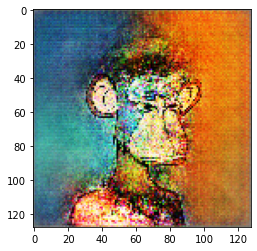

Time for epoch 2 is 119.87275695800781 || Total Discriminator Loss = 0.4676595628261566 || Generator Loss (Trick) = 1.7858266830444336 || Fake accuracy = 0.25 || Real accuracy = 1.0


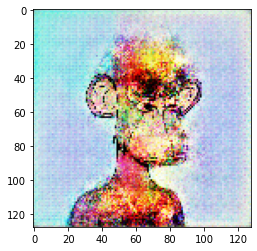

Time for epoch 3 is 115.12010669708252 || Total Discriminator Loss = 0.3851304352283478 || Generator Loss (Trick) = 2.1623733043670654 || Fake accuracy = 1.0 || Real accuracy = 0.8125


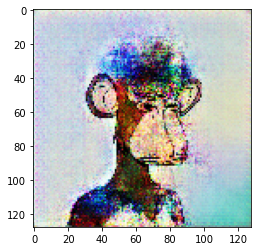

Time for epoch 4 is 115.84991955757141 || Total Discriminator Loss = 0.3506823778152466 || Generator Loss (Trick) = 2.4455368518829346 || Fake accuracy = 0.875 || Real accuracy = 0.875


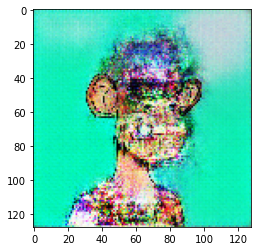

Time for epoch 5 is 117.22687339782715 || Total Discriminator Loss = 0.33492913842201233 || Generator Loss (Trick) = 2.556992292404175 || Fake accuracy = 1.0 || Real accuracy = 0.6875


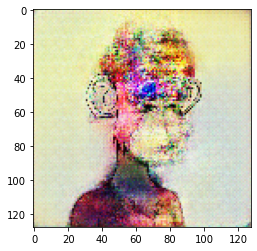

Time for epoch 6 is 117.420166015625 || Total Discriminator Loss = 0.3106810450553894 || Generator Loss (Trick) = 2.536979913711548 || Fake accuracy = 1.0 || Real accuracy = 0.9375


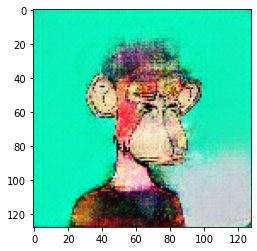

Time for epoch 7 is 114.5679669380188 || Total Discriminator Loss = 0.28028813004493713 || Generator Loss (Trick) = 2.663846731185913 || Fake accuracy = 1.0 || Real accuracy = 0.875


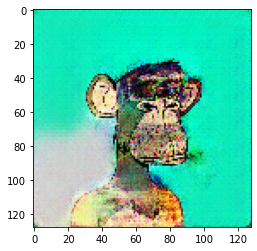

Time for epoch 8 is 117.59950280189514 || Total Discriminator Loss = 0.2616707384586334 || Generator Loss (Trick) = 2.7519278526306152 || Fake accuracy = 1.0 || Real accuracy = 0.875


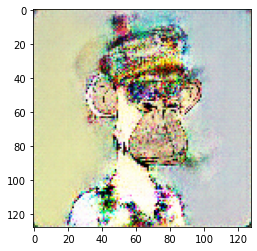

Time for epoch 9 is 123.9662675857544 || Total Discriminator Loss = 0.2400466352701187 || Generator Loss (Trick) = 2.884056806564331 || Fake accuracy = 1.0 || Real accuracy = 0.8125


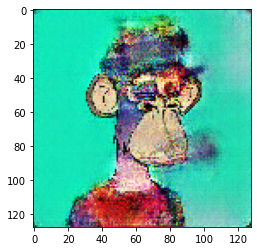

Time for epoch 10 is 122.79207873344421 || Total Discriminator Loss = 0.22002820670604706 || Generator Loss (Trick) = 3.1159801483154297 || Fake accuracy = 1.0 || Real accuracy = 0.9375


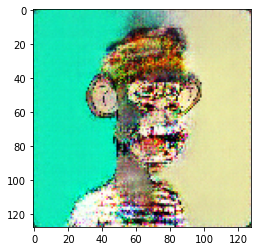

Time for epoch 11 is 119.53522396087646 || Total Discriminator Loss = 0.21129469573497772 || Generator Loss (Trick) = 3.2208518981933594 || Fake accuracy = 0.125 || Real accuracy = 1.0


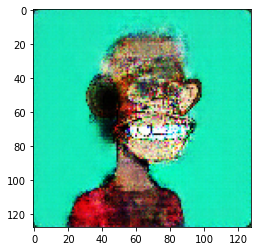

Time for epoch 12 is 115.85377836227417 || Total Discriminator Loss = 0.19436600804328918 || Generator Loss (Trick) = 3.3786449432373047 || Fake accuracy = 1.0 || Real accuracy = 0.8125


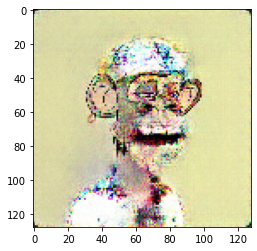

Time for epoch 13 is 117.217529296875 || Total Discriminator Loss = 0.18784649670124054 || Generator Loss (Trick) = 3.5275301933288574 || Fake accuracy = 1.0 || Real accuracy = 0.8125


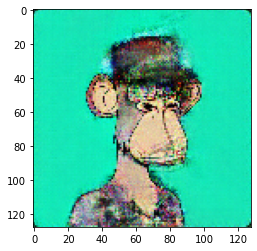

Time for epoch 14 is 116.8209900856018 || Total Discriminator Loss = 0.17546804249286652 || Generator Loss (Trick) = 3.6728851795196533 || Fake accuracy = 1.0 || Real accuracy = 0.75


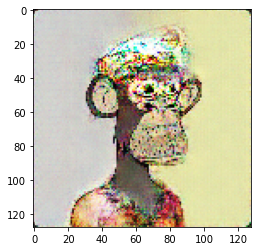

Time for epoch 15 is 113.96904444694519 || Total Discriminator Loss = 0.1684470921754837 || Generator Loss (Trick) = 3.8287181854248047 || Fake accuracy = 0.9375 || Real accuracy = 1.0


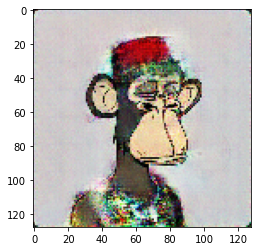

Time for epoch 16 is 121.13173079490662 || Total Discriminator Loss = 0.17835421860218048 || Generator Loss (Trick) = 3.8473644256591797 || Fake accuracy = 1.0 || Real accuracy = 0.875


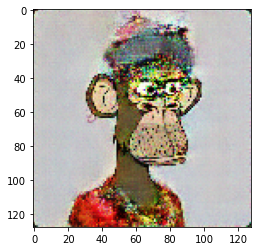

Time for epoch 17 is 115.93890571594238 || Total Discriminator Loss = 0.16657742857933044 || Generator Loss (Trick) = 3.9563164710998535 || Fake accuracy = 0.9375 || Real accuracy = 1.0


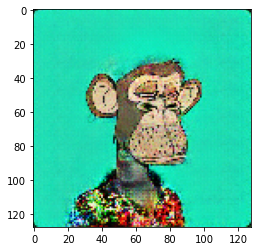

Time for epoch 18 is 111.72636699676514 || Total Discriminator Loss = 0.16205164790153503 || Generator Loss (Trick) = 4.0268707275390625 || Fake accuracy = 1.0 || Real accuracy = 0.6875


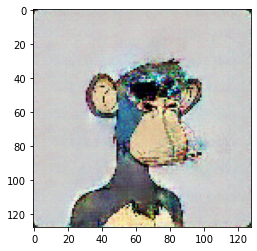

Time for epoch 19 is 115.42015981674194 || Total Discriminator Loss = 0.15904413163661957 || Generator Loss (Trick) = 4.1145243644714355 || Fake accuracy = 0.5625 || Real accuracy = 0.9375


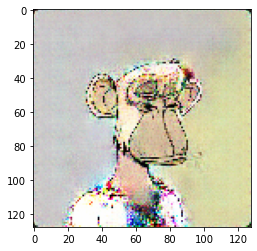

Time for epoch 20 is 113.43737387657166 || Total Discriminator Loss = 0.15034542977809906 || Generator Loss (Trick) = 4.179530620574951 || Fake accuracy = 1.0 || Real accuracy = 0.6875


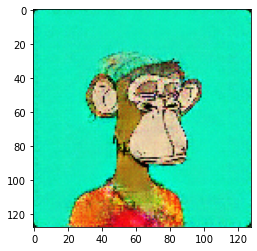

In [12]:
train_the_model(dataset, 20, noise_dimensions, GAN)